# Offline classification model training

This notebook describe the CNN training for performing the gait representation (GEI) classification task. For replication purposes, is recommended to run this notebook on [Google Colab](https://colab.research.google.com/?hl=en) making use of the GPU runtime.

## Preparing the environment for TensorRT with GPU usage

In [1]:
%%bash
pip install pillow matplotlib
pip install tensorflow-gpu==2.0.0
pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=9086c3a660952b350c63e3d335a0429b174155588b47a954cf6c754e22391cb5
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
Lo

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.0.2 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.0.1 which is incompatible.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.0.2 which is incompatible.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorflow-estimator<2.9,>=2.8, but you have tensorflow-estimator 2.0.1 which is incompatible.


In [2]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

sudo apt-get install libnvinfer5

Selecting previously unselected package nvidia-machine-learning-repo-ubuntu1804.
(Reading database ... 155569 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [92.1 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:

--2022-09-19 01:44:15--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.199.39.144
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.199.39.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’

     0K ..                                                    100%  160M=0s

2022-09-19 01:44:15 (160 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/nvidia-machine-learning.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list:51 and /etc/apt/sources.list.d/nvidia-machine-learni

In [3]:
# check TensorRT version
print("TensorRT version: ")
!dpkg -l | grep nvinfer

TensorRT version: 
ii  libnvinfer5                             5.1.5-1+cuda10.1                    amd64        TensorRT runtime libraries


In [4]:
!unzip /content/training_representations.zip

Archive:  /content/training_representations.zip
   creating: training_representations/
   creating: training_representations/000/
  inflating: training_representations/000/060-nm-03-2.png  
  inflating: training_representations/000/060-nm-05-2.png  
  inflating: training_representations/000/060-nm-01-3.png  
  inflating: training_representations/000/060-nm-03-1.png  
  inflating: training_representations/000/060-nm-02-2.png  
  inflating: training_representations/000/060-nm-01-1.png  
  inflating: training_representations/000/060-nm-05-1.png  
  inflating: training_representations/000/060-nm-01-2.png  
  inflating: training_representations/000/060-nm-04-2.png  
  inflating: training_representations/000/060-nm-02-1.png  
  inflating: training_representations/000/060-nm-04-1.png  
  inflating: training_representations/000/060-bg-03-2.png  
  inflating: training_representations/000/060-bg-05-2.png  
  inflating: training_representations/000/060-bg-03-1.png  
  inflating: training_represen

## Import libraries and pre-processing

In [1]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.python.saved_model import tag_constants
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
datagenerator = ImageDataGenerator(rescale = 1/255.,
                                   width_shift_range=0.01, # horizontal shift
                                   horizontal_flip=True, # horizontal flip
                                   validation_split=0.2) 

In [8]:
training_data = '/content/training_representations'


img_height = 220
img_width = 220
batch_size = 4

train_ds = datagenerator.flow_from_directory(
    training_data,
    color_mode='grayscale',
    class_mode = "categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset = "training"
)

val_ds = datagenerator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = "categorical",
    subset = "validation"
)

Found 2166 images belonging to 17 classes.
Found 534 images belonging to 17 classes.


In [2]:
classes = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016']
print(classes)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']


In [10]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(4, 220, 220, 1)


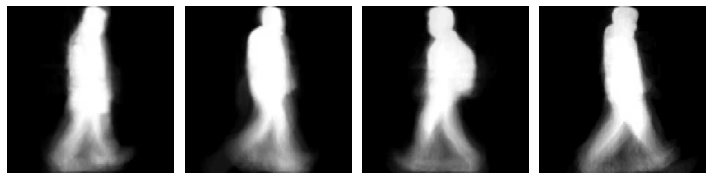

In [11]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:4])

## CNN model definition and training

In [4]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(16, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))


model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(75, kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.Dropout(0.50))
model_cnn.add(keras.layers.Dense(len(classes), activation = "softmax"))

model_cnn.build((None, 220, 220, 1))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 220, 220, 16)      160       
                                                                 
 activation_6 (Activation)   (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 activation_7 (Activation)   (None, 110, 110, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                  

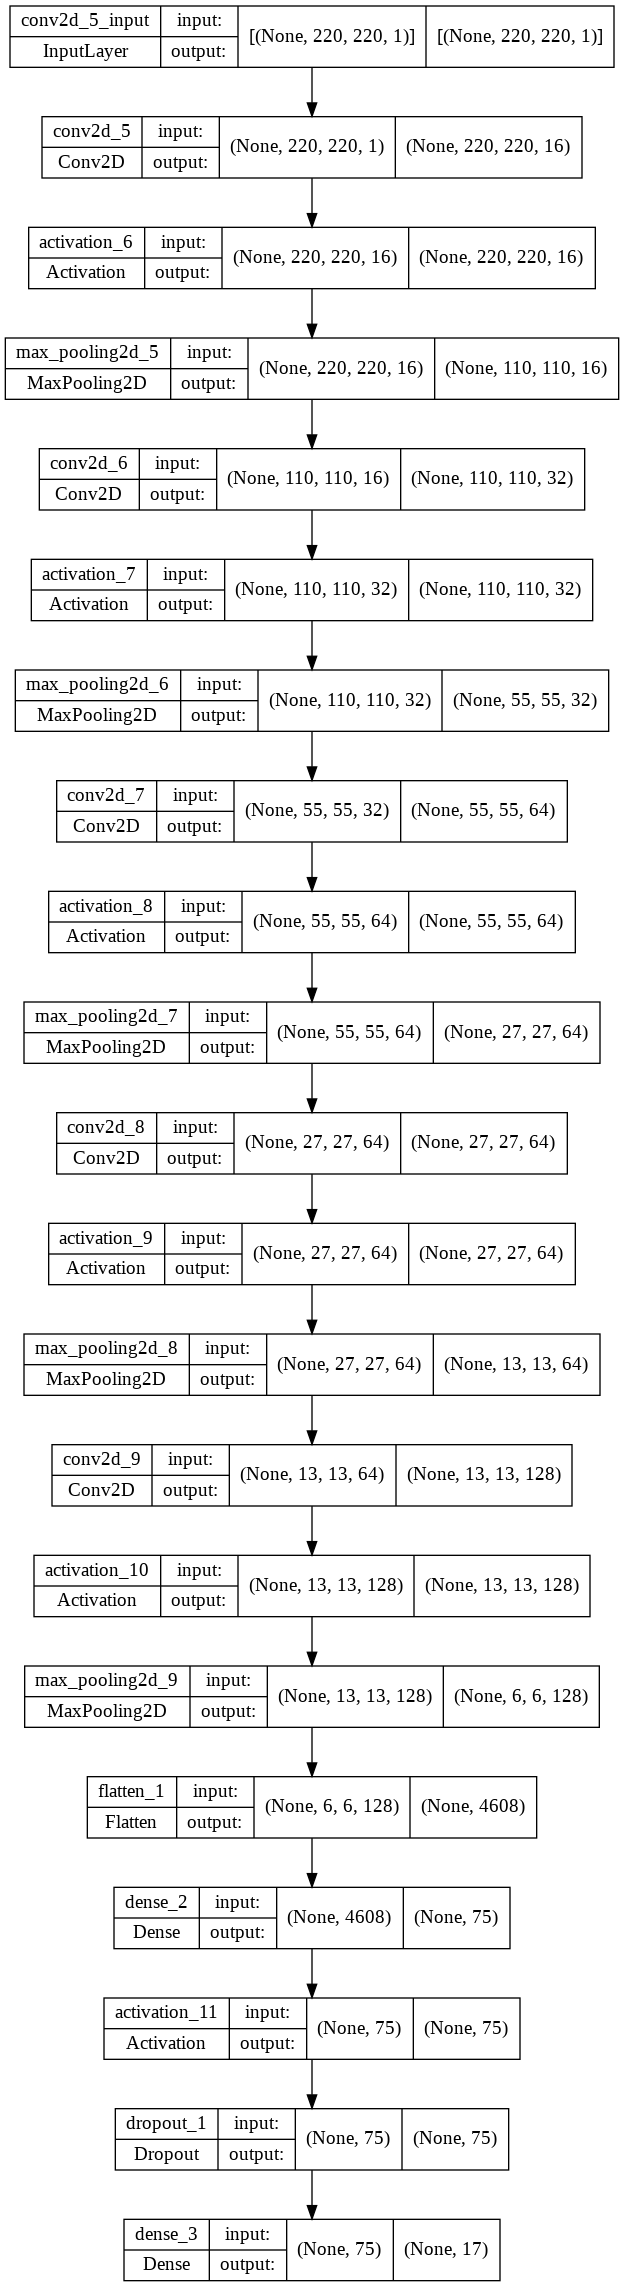

In [5]:
keras.utils.plot_model(model_cnn, show_shapes=True)

In [25]:
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get("val_accuracy") > 0.93:
      print("Achieved")
      self.model.stop_training = True

In [26]:
epochs = 25
optimizer = keras.optimizers.SGD(
    learning_rate=0.0001, momentum=0.9,  decay=1e-6, nesterov=True, name="SGD")

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

callback = TrainingCallback()


model_cnn.compile(optimizer=optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
training_samples = train_ds.n
val_samples = val_ds.n
history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    callbacks = [callback],
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Train for 541 steps, validate for 133 steps
Epoch 1/25
541/541 [==============================] - 14s 25ms/step - loss: 3.0664 - accuracy: 0.0717 - val_loss: 3.0125 - val_accuracy: 0.1071
Epoch 2/25
541/541 [==============================] - 13s 24ms/step - loss: 2.9124 - accuracy: 0.1105 - val_loss: 2.5882 - val_accuracy: 0.2406
Epoch 3/25
541/541 [==============================] - 14s 25ms/step - loss: 2.1551 - accuracy: 0.3571 - val_loss: 1.6885 - val_accuracy: 0.4868
Epoch 4/25
541/541 [==============================] - 13s 24ms/step - loss: 1.4857 - accuracy: 0.5772 - val_loss: 1.2604 - val_accuracy: 0.6128
Epoch 5/25
541/541 [==============================] - 14s 26ms/step - loss: 1.0674 - accuracy: 0.7239 - val_loss: 1.1916 - val_accuracy: 0.6504
Epoch 6/25
541/541 [==============================] - 13s 23ms/step - loss: 0.8711 - accuracy: 0.7891 - val_loss: 0.8361 - val_accuracy: 0.7726
Epoch 7/25
541/541 [==============================] - 13s 23ms/step - loss: 0.7450 - accurac

In [29]:
def visualizacion_resultados(history):
  nepochs = [i for i in range(20)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(nepochs, train_acc, "-", label =" Training accuracy")
  ax[0].plot(nepochs, val_acc, "-", label= "Validation accuracy")
  ax[0].set_title("Training & validation accuracy")
  ax[0].legend()
  ax[0].set_xlabel("nEpochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(nepochs, train_loss, "-", label =" Training Loss")
  ax[1].plot(nepochs, val_loss, "-", label= "Validation Loss")
  ax[1].set_title("Training & validation Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

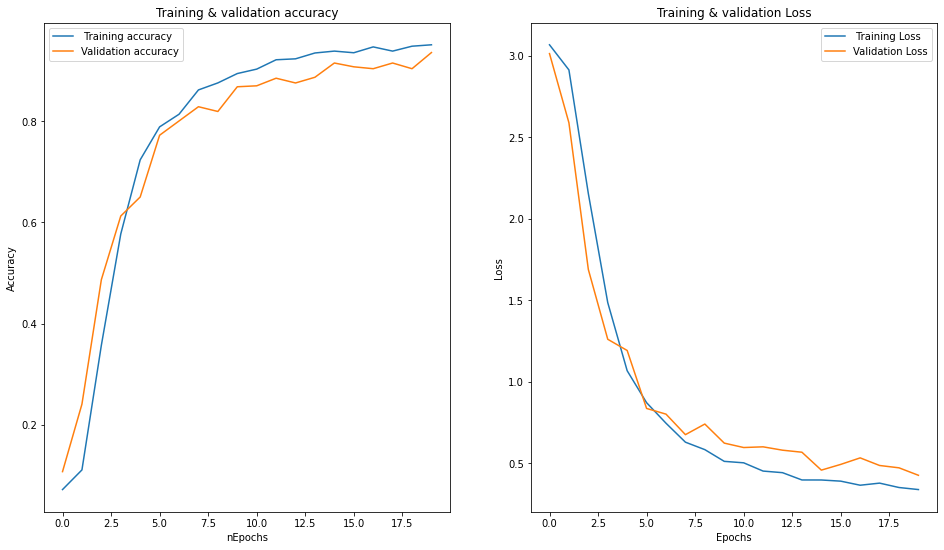

In [30]:
visualizacion_resultados(history_cnn)

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



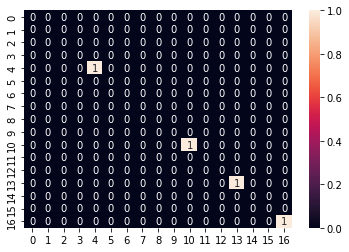

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics

test_batch = []
for data in next(val_ds):
  test_batch.append(data)

image_batch = test_batch[0]
label_batch = test_batch[1] 

predictions = np.argmax(model_cnn.predict(image_batch), axis=1)
label_batch = np.argmax(label_batch, axis=1)
cf_matrix = tf.math.confusion_matrix(label_batch, predictions)
sns.heatmap(cf_matrix, annot=True)
f1_score = metrics.classification_report(label_batch, predictions)
print(f1_score)

In [33]:
model_cnn.save("cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261")

## Convert Keras model into TensorRT model

This section will describe the process for converting the saved Keras model into a TensorRT model capable of being deployed in the Jetson Nano GPU. This part of the notebook is based on the following colab notebook [Step1_Colab_TensorRT](https://colab.research.google.com/github/Tony607/tf_jetson_nano/blob/master/Step1_Colab_TensorRT.ipynb).

### Optimize for FP16 with TensorRT

In [34]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(
   input_saved_model_dir='cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
Done Converting to TF-TRT FP16


In [35]:
!saved_model_cli show --all --dir cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261_TFTRT_FP16


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 220, 220, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
        dtype: DT_FLOAT
        shape: unknown_rank
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict


### Keras vs. TensorRT inference speed comparison

In [38]:
img_path = '/content/060-bg-02.png'
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = image/255.0
GEI = tf.reshape(image, [-1,220,220,1])
GEI = tf.dtypes.cast(GEI, tf.float32)

In [39]:
saved_model_loaded = tf.saved_model.load('cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261_TFTRT_FP16', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

['serving_default']


In [40]:
infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

{'output_1': TensorSpec(shape=<unknown>, dtype=tf.float32, name='output_1')}


In [41]:
import time 
import numpy as np

start_time = time.time()
pred = model_cnn(GEI)
end_time = time.time()

print(int(tf.argmax(pred,axis=1)))
print((end_time-start_time)*1000,' ms')

1
120.30196189880371  ms


In [43]:
start_time = time.time()
pred = infer(GEI)
end_time = time.time()

index = int(tf.argmax(np.asarray(pred['output_1']),axis=1))
print(index)
print(np.asarray(pred['output_1'])[0][index])
print((end_time-start_time)*1000,' ms')

1
0.9712775
1.562356948852539  ms


In [44]:
import os
os.system("zip -r cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261_TFTRT_FP16.zip cnn_gait_recognition_acc_0.9514_loss_0.3384_val_acc_0.9361_loss_acc_0.4261_TFTRT_FP16")

0